In [1]:
%pip install pydub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.api._v2.keras.layers.experimental import preprocessing
from keras import layers
from keras import models
import tensorflow_datasets as tfds

2023-06-13 21:05:17.696263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/elisacastelli/opt/miniconda3/envs/conda_th/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = tfds.load('GTZANMusicSpeech', split='train', shuffle_files=True)

2023-06-13 21:05:25.693564: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Extraction completed...: 0 file [00:07, ? file/s]
Dl Size...: 0 MiB [00:07, ? MiB/s]
Dl Completed...:   0%|          | 0/1 [00:08<?, ? url/s]


KeyboardInterrupt: 

In [4]:
#data_dir = pathlib.Path('/root/tensorflow_datasets/downloads/extracted/TAR_GZ.opihi.cs.uvic.ca_sound_music_speechbya81rFcWfLSW6ey5cynqyeq2qiePcL-7asMoNO6IQ0.tar.gz/music_speech')

data_dir = "/Users/elisacastelli/Downloads/archive"

In [5]:
categories = np.array(tf.io.gfile.listdir(str(data_dir)))
categories = [category for category in categories if 'wav' in category]

In [6]:
print(categories)

['speech_wav', 'music_wav']


In [7]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = [filename for filename in filenames if 'wav' in filename]
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
#print('Number of examples per label:',      len(tf.io.gfile.listdir(str(data_dir/categories[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 256
Example file tensor: tf.Tensor(b'/Users/elisacastelli/Downloads/archive/dataset/pulp1.wav', shape=(), dtype=string)


In [8]:
TRAIN_SIZE = 0.75

train_files = filenames[:int(len(filenames) * TRAIN_SIZE)]
val_files = filenames[int(len(filenames) * TRAIN_SIZE):]

print('Training set size:', len(train_files))
print('Validation set size:', len(val_files))

Training set size: 192
Validation set size: 64


In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
def get_waveform_and_labelMP3(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    #waveform = decode_audio(audio_binary)
    return audio_binary, label

In [11]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [12]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary) # returns the WAV-encoded audio as a tensor and the sample rate
  return tf.squeeze(audio, axis=-1) # removes dimensions of size 1 from the last axis

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [14]:
def get_spectrogram(waveform):
    # produces an array of complex numbers representing magnitude and phase
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)

    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [15]:
for waveform, label in waveform_ds.take( 1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
# print('Audio playback')
# display.display(display.Audio(waveform, rate=16000))

2023-06-13 21:07:03.484141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [192]
	 [[{{node Placeholder/_0}}]]


Label: dataset
Waveform shape: (661500,)
Spectrogram shape: (5166, 129)


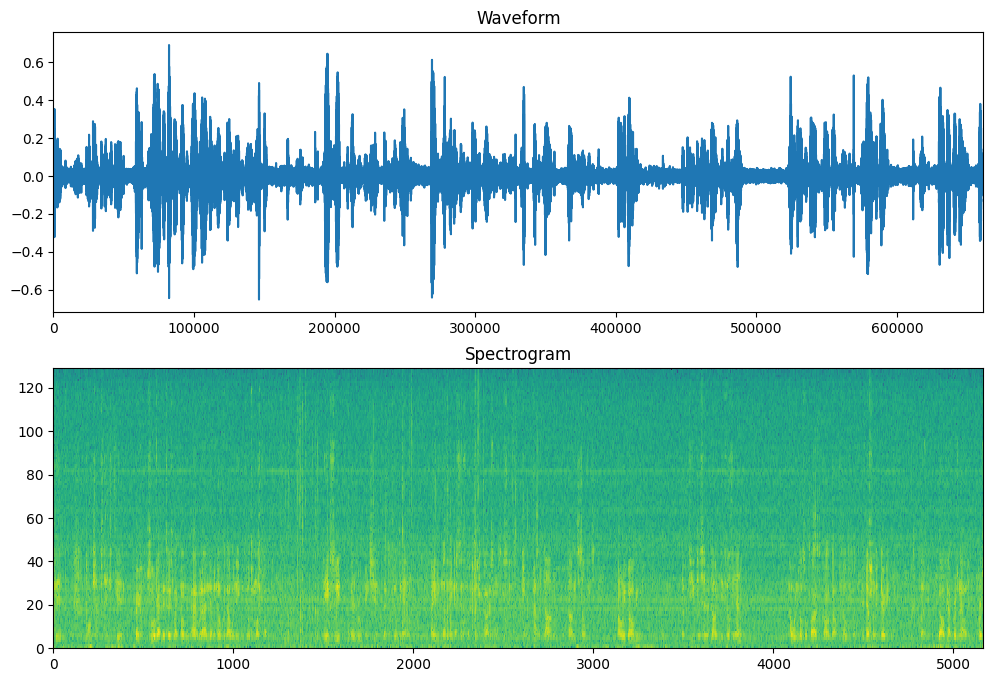

In [16]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  ax.pcolormesh(log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 661500])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == categories)
  return spectrogram, label_id

In [18]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [19]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [20]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)

In [21]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [22]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

print('Input shape:', input_shape)
num_labels = len(categories)

2023-06-13 21:08:01.740397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [192]
	 [[{{node Placeholder/_0}}]]
2023-06-13 21:08:01.741001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [192]
	 [[{{node Placeholder/_0}}]]


Input shape: (5166, 129, 1)


In [23]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(64, 64), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

2023-06-13 21:08:03.984339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [192]
	 [[{{node Placeholder/_0}}]]
2023-06-13 21:08:03.984558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [192]
	 [[{{node Placeholder/_0}}]]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 64, 64, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

2023-06-13 21:08:13.269535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [192]
	 [[{{node Placeholder/_0}}]]
2023-06-13 21:08:13.270643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [192]
	 [[{{node Placeholder/_0}}]]


Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 1.1934 - accuracy: 0.5938

2023-06-13 21:08:24.099037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-13 21:08:24.099383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


6/6 [==============================] - 13s 2s/step - loss: 1.1934 - accuracy: 0.5938 - val_loss: 0.5961 - val_accuracy: 0.7656
Epoch 2/10
6/6 [==============================] - 2s 265ms/step - loss: 0.5658 - accuracy: 0.7396 - val_loss: 0.6071 - val_accuracy: 0.7656
Epoch 3/10
6/6 [==============================] - 2s 288ms/step - loss: 0.5216 - accuracy: 0.7448 - val_loss: 0.5672 - val_accuracy: 0.7656
Epoch 4/10
6/6 [==============================] - 2s 268ms/step - loss: 0.5029 - accuracy: 0.7396 - val_loss: 0.5521 - val_accuracy: 0.7656
Epoch 5/10
6/6 [==============================] - 2s 274ms/step - loss: 0.4563 - accuracy: 0.7500 - val_loss: 0.5341 - val_accuracy: 0.7344
Epoch 6/10
6/6 [==============================] - 2s 265ms/step - loss: 0.4189 - accuracy: 0.7500 - val_loss: 0.5148 - val_accuracy: 0.7031
Epoch 7/10
6/6 [==============================] - 2s 269ms/step - loss: 0.3935 - accuracy: 0.7656 - val_loss: 0.5355 - val_accuracy: 0.6719
Epoch 8/10
6/6 [=================

In [26]:
import librosa as lib

audio, sr = lib.load("/Users/elisacastelli/Documents/GitHub/HitPrediction/HitSongPrediction/Audio/2Dqrtex0EzkYeV2EyTzb2g.mp3")
print(audio.shape)
spec = tf.signal.stft(audio, frame_length=255, frame_step=128)
spec=tf.abs(spec)
print(spec.shape)
spec = tf.expand_dims(spec, -1)
spec = tf.expand_dims(spec, 0)
print(spec.shape)
result = model.predict(spec)

if result[0][0]>result[0][1]:
    print(result, "--> Speech")
else:
    print(result, "--> Music")


(661500,)
(5166, 129)
(1, 5166, 129, 1)
1/1 [==============================] - 0s 147ms/step
[[ 1.6316079 -1.229612 ]] --> Speech
